In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

sns.set(style="whitegrid")

rng = np.random.default_rng(seed=42)

mu, sigma = 15, 3

lmb = 0.4

n, p = 20, 0.3

sample_sizes = [100, 500, 1000]

theoretical_params = {
    "normal": (mu, sigma**2),
    "exponential": (1 / lmb, 1 / lmb**2),
    "binomial": (n * p, n * p * (1 - p)),
}

names = {
    "normal": "Нормальное",
    "exponential": "Экспоненциальное",
    "binomial": "Биномиальное",
}


def fd_bins(data: pd.Series):
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * iqr * (n ** (-1 / 3))
    bins_fd = int(np.ceil((data.max() - data.min()) / bin_width))

    return bins_fd

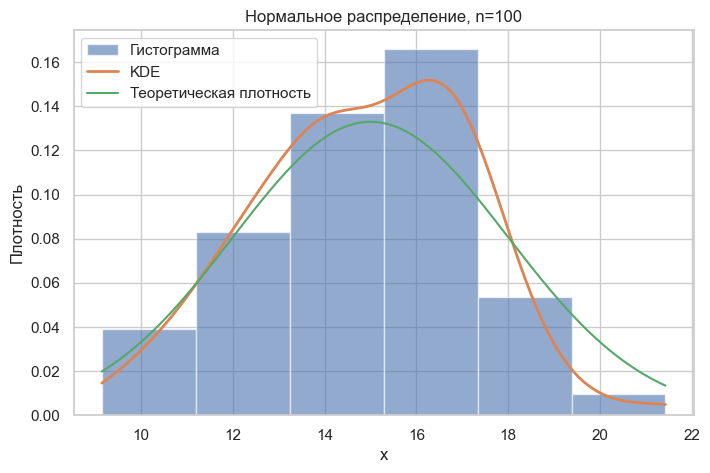

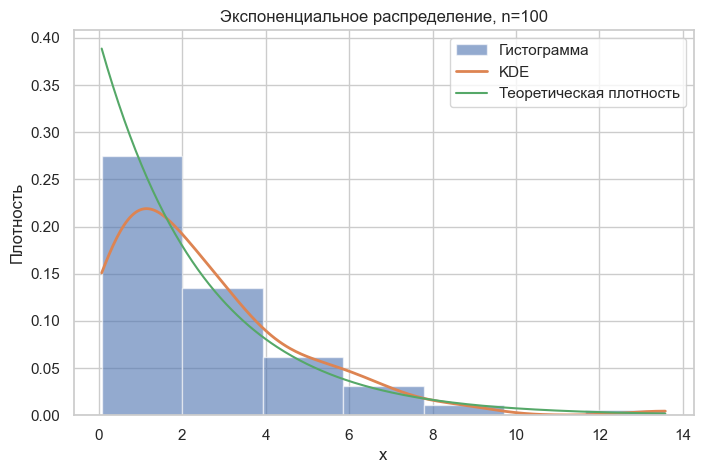

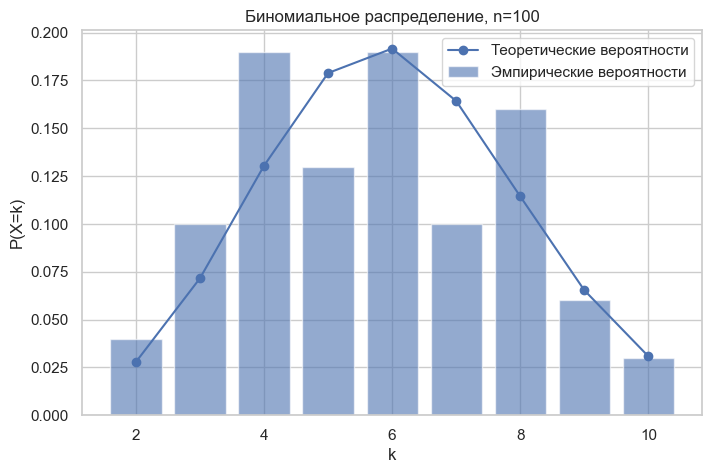

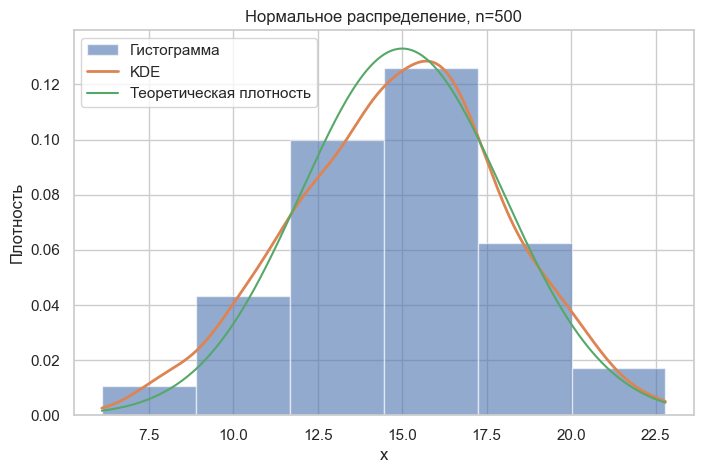

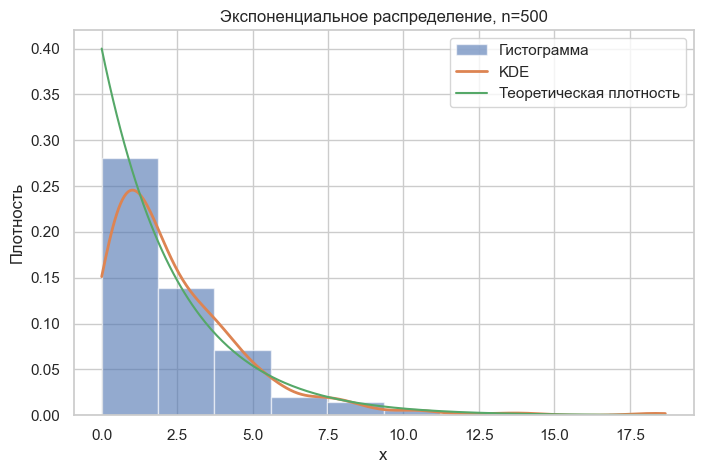

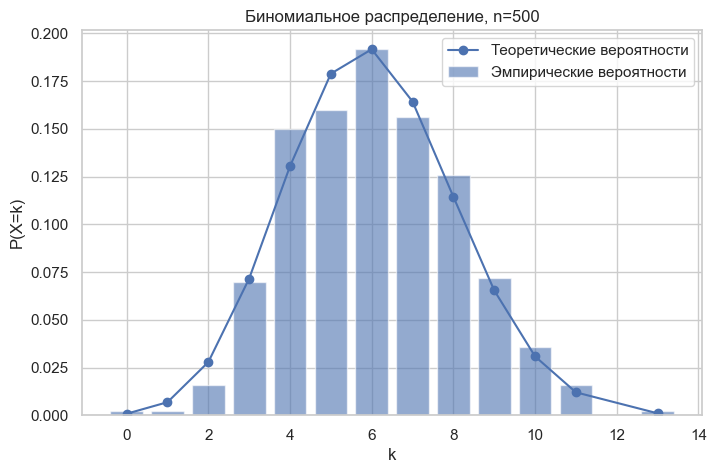

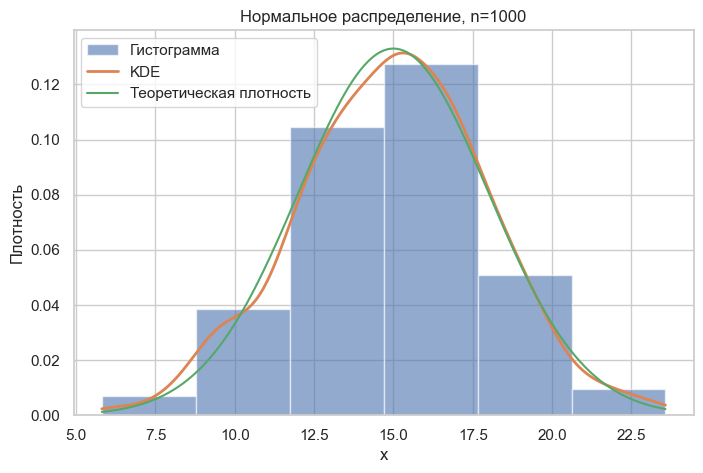

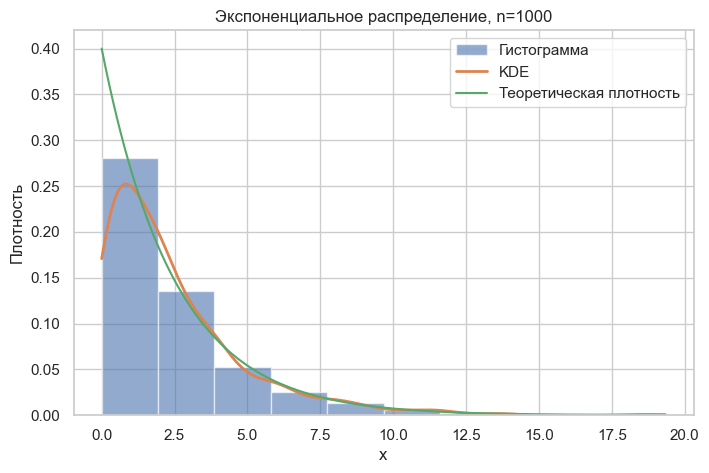

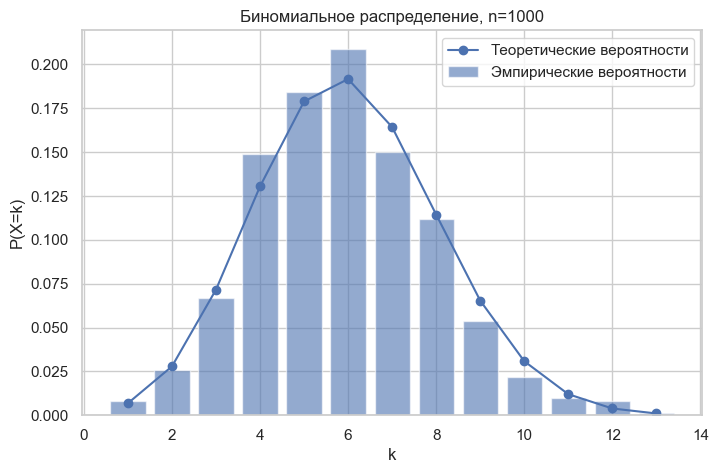

In [2]:
normal = stats.norm(mu, sigma)
exponential = stats.expon(0, 1 / lmb)
binomial = stats.binom(n, p)

results = []

for size in sample_sizes:
    normal_dist = normal.rvs(size, random_state=rng)
    exponential_dist = exponential.rvs(size, random_state=rng)
    binomial_dist = binomial.rvs(size, random_state=rng)

    samples = {
        "normal": normal_dist,
        "exponential": exponential_dist,
        "binomial": binomial_dist,
    }

    for name, sample in samples.items():
        mean = sample.mean()
        var = sample.var(ddof=1)

        theor_mean, theor_var = theoretical_params[name]

        cv = np.sqrt(var) / mean

        err_mean = abs(mean - theor_mean) / theor_mean * 100
        err_var = abs(var - theor_var) / theor_var * 100

        results.append([name, size, mean, var, cv, err_mean, err_var])

        plt.figure(figsize=(8, 5))

        if name == "binomial":
            values, counts = np.unique(sample, return_counts=True)
            probs_emp = counts / size
            probs_theor = stats.binom.pmf(values, n, p)

            plt.bar(values, probs_emp, alpha=0.6, label="Эмпирические вероятности")
            plt.plot(values, probs_theor, "o-", label="Теоретические вероятности")

            plt.xlabel("k")
            plt.ylabel("P(X=k)")
            plt.title(f"{names[name]} распределение, n={size}")

        else:
            bins = fd_bins(sample)
            plt.hist(sample, bins=bins, density=True, alpha=0.6, label="Гистограмма")

            kde = stats.gaussian_kde(sample)
            x = np.linspace(sample.min(), sample.max(), 300)
            plt.plot(x, kde(x), label="KDE", linewidth=2)

            if name == "normal":
                plt.plot(
                    x, stats.norm.pdf(x, mu, sigma), label="Теоретическая плотность"
                )
            else:
                plt.plot(
                    x,
                    stats.expon.pdf(x, scale=1 / lmb),
                    label="Теоретическая плотность",
                )

            plt.xlabel("x")
            plt.ylabel("Плотность")
            plt.title(f"{names[name]} распределение, n={size}")

        plt.legend()
        plt.show()

In [3]:
df_results = pd.DataFrame(
    results,
    columns=[
        "Распределение",
        "Объем выборки",
        "Среднее",
        "Дисперсия",
        "Коэф. вариации",
        "Ошибка среднего (%)",
        "Ошибка дисперсии (%)",
    ],
)

df_results

,Распределение,Объем выборки,Среднее,Дисперсия,Коэф. вариации,Ошибка среднего (%),Ошибка дисперсии (%)
0,normal,100,14.849191,5.429048,0.156913,1.005392,39.677250
1,exponential,100,2.502837,5.268395,0.917079,0.113482,15.705685
2,binomial,100,5.750000,4.169192,0.355106,4.166667,0.733526
3,normal,500,14.907028,9.388290,0.205543,0.619811,4.314335
4,exponential,500,2.481179,6.031083,0.989782,0.752836,3.502668
5,binomial,500,6.106000,4.147058,0.333513,1.766667,1.260521
6,normal,1000,14.966820,9.033369,0.200815,0.221197,0.370763
7,exponential,1000,2.424573,6.011579,1.011251,3.017076,3.814736
8,binomial,1000,5.902000,4.016412,0.339563,1.633333,4.371133


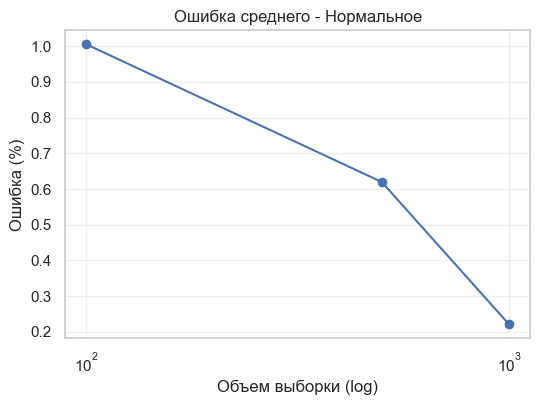

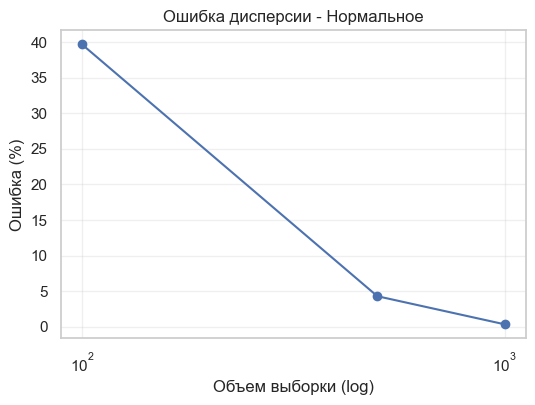

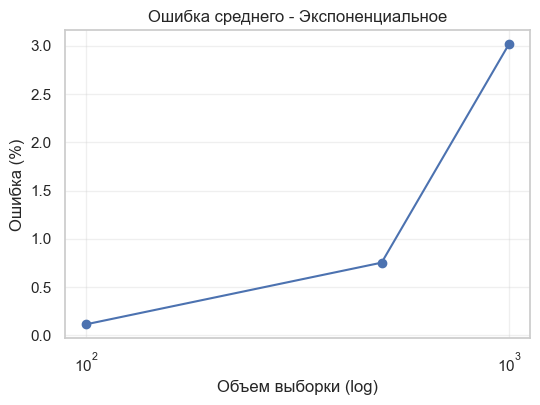

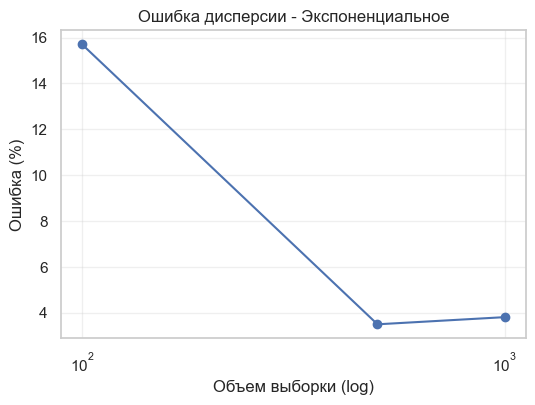

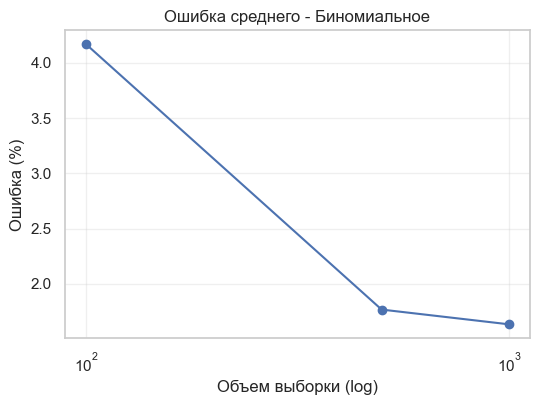

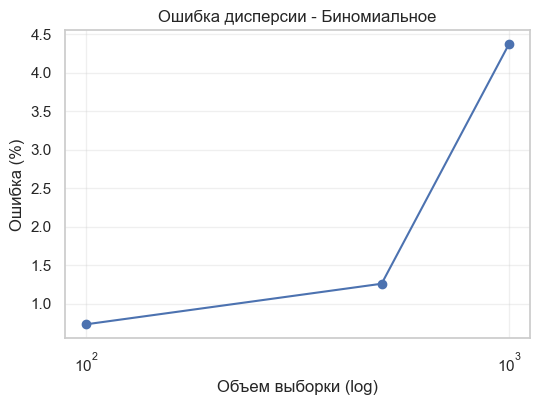

In [4]:
for dist in df_results["Распределение"].unique():
    sub = df_results[df_results["Распределение"] == dist]

    plt.figure(figsize=(6, 4))
    plt.plot(sub["Объем выборки"], sub["Ошибка среднего (%)"], marker="o")
    plt.xscale("log")
    plt.title(f"Ошибка среднего - {names[dist]}")
    plt.xlabel("Объем выборки (log)")
    plt.ylabel("Ошибка (%)")
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(sub["Объем выборки"], sub["Ошибка дисперсии (%)"], marker="o")
    plt.xscale("log")
    plt.title(f"Ошибка дисперсии - {names[dist]}")
    plt.xlabel("Объем выборки (log)")
    plt.ylabel("Ошибка (%)")
    plt.grid(alpha=0.3)
    plt.show()

Нормальное, n=1000, p-value Шапиро–Уилка: 0.3011


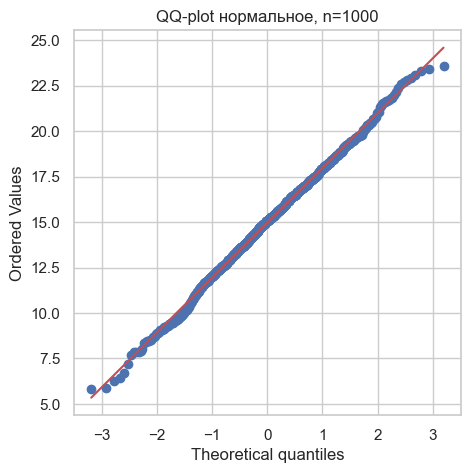

Экспоненциальное, n=1000, p-value Колмогорова-Смирнова: 0.4813


In [5]:
_, p = stats.shapiro(normal_dist)
print(f"Нормальное, n={size}, p-value Шапиро–Уилка: {p:.4f}")

plt.figure(figsize=(5, 5))
stats.probplot(normal_dist, dist="norm", plot=plt)
plt.title(f"QQ-plot нормальное, n={size}")
plt.show()

_, p = stats.kstest(exponential_dist, "expon", args=(0, 1 / lmb))
print(f"Экспоненциальное, n={size}, p-value Колмогорова-Смирнова: {p:.4f}")